### Grayson Arthofer

### Investing in Precious Metals

## Part 1) Data Extraction/ Creating Panda Dataframes

#### Using JSON(JavaScript object notation) to extract gold and silver prices
Quandl.com contains time series data that can be extracted using json

In [1]:
from bs4 import BeautifulSoup
import requests 
import numpy as np
import requests_cache
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import plotnine as p9
from datetime import datetime
requests_cache.install_cache('quandl_cache')

In [2]:
key = 'BF_VUsYZA-MyNiBC_cq3'
params = {'api_key': key}
#https://www.quandl.com/data/LBMA/SILVER-Siver-Price-London-Fixing
AG_url = 'https://www.quandl.com/api/v3/datasets/LBMA/SILVER.json'

###https://www.quandl.com/data/LBMA/GOLD
AU_url = 'https://www.quandl.com/api/v3/datasets/LBMA/GOLD.json'

In [3]:
###Getting the url for json format
AG_req = requests.get(AG_url, params = params)
AU_req = requests.get(AU_url, params = params)

In [4]:
#Parse the JSON
AG_Json = AG_req.json() 
AU_Json = AU_req.json()

In [5]:
#Extracts the data while ignoring additional text
AG_List = AG_Json['dataset']['data']
colnames = ['date', 'USD_silver', 'GBP', 'EURO']
#Creating a panda dataframe for gold prices
AG_df = pd.DataFrame(AG_List, columns = colnames)
###I will only be looking at USD prices for silver
AG_df = AG_df.drop(columns = ['GBP', 'EURO'])
AG_df['date'] = pd.to_datetime(AG_df['date'])

In [6]:
AU_List = AU_Json['dataset']['data']
colnames = ['date', 'USD_gold', 'USD_PM', 'GBP_AM', 'GBP_PM', 'EURO_AM', 'EURO_PM']
AU_df = pd.DataFrame(AU_List, columns = colnames)
###I will only be looking at AM USD prices for gold
AU_df = AU_df.drop(columns = ['USD_PM', 'GBP_AM', 'GBP_PM', 'EURO_AM', 'EURO_PM'])
AU_df['date'] = pd.to_datetime(AU_df['date'])

In [7]:
#Metal prices are merged into one dataframe
#Date columns were dtype object. The function below automatically converts date from object to string Dtype.
Metals_df = pd.merge(AU_df, AG_df, how='inner', on='date')
Metals_df['date'] = pd.to_datetime(Metals_df['date'])
Metals_df = Metals_df.convert_dtypes()
Metals_df.head()

,date,USD_gold,USD_silver
0,2021-05-28,1892.45,27.630
1,2021-05-27,1895.05,27.655
2,2021-05-26,1904.30,28.120
3,2021-05-25,1882.80,27.555
4,2021-05-24,1876.85,27.645


#### Using webscraping to collect data from Yahoo Finance

Here I will be collecting monthly data from IAU and SLV

In [8]:
###Gold and Silver Trust sources
url_IAU = 'https://finance.yahoo.com/quote/IAU/history'
url_SLV = 'https://finance.yahoo.com/quote/SLV/history'
params_SLV = {'period1':'694310400','period2':'1622505600','interval':'1d','filter':'history','frequency':'1d','includeAdjustedClose':'true'}
params_IAU = {'period1':'146096000','period2':'1620518400','interval':'1mo','filter':'history','frequency':'1d','includeAdjustedClose':'true'}
req_SLV = requests.get(url_SLV, params = params_IAU)
req_IAU = requests.get(url_IAU, params = params_IAU)

In [9]:
#Converting the html into text
SLV_html = req_SLV.text
SLV = BeautifulSoup(SLV_html, 'lxml')
IAU_html = req_IAU.text
IAU = BeautifulSoup(IAU_html, 'lxml')

In [10]:
#Selecting the part of the html that contains relevant data
IAU_content = IAU.find_all(name = 'tbody')
IAU_content = IAU_content[0]
SLV_content = SLV.find_all(name = 'tbody')
SLV_content = SLV_content[0]

In [11]:
###Creating empty list
data_IAU = []
###Iterating through each tr tag. Each tr tag represents a row of data on Yahoo Finance
IAU_reader = IAU_content.find_all(name = 'tr')
for tr in IAU_reader:
    #td span indicates the beginning of each datapoint in a row
    cols = tr.select('td span')
    cols = [col.get_text() for col in cols]
    data_IAU.append(cols)

    
data_SLV = []
SLV_reader = SLV_content.find_all(name = 'tr')
for tr in SLV_reader:
    cols = tr.select('td span')
    cols = [col.get_text() for col in cols]
    data_SLV.append(cols)


##Assign column names
colnames1 = ['date', 'IAU_open', 'high', 'low', 'close', 'adj_close', 'volume']
colnames2 = ['date', 'SLV_open', 'high', 'low', 'close', 'adj_close', 'volume']
IAU_df = pd.DataFrame(data_IAU, columns = colnames1)
IAU_df = IAU_df.drop(columns = ['high', 'low', 'close', 'adj_close', 'volume'])
SLV_df = pd.DataFrame(data_SLV, columns = colnames2)
SLV_df = SLV_df.drop(columns = ['high', 'low', 'close', 'adj_close', 'volume'])

In [12]:
#All of the columns were dtype object. The function below automatically converts the dtypes to the best possible dtypes.
#The dates were correctly converted to strings but not the prices of the ETFs had to be converted manually
IAU_df = IAU_df.convert_dtypes()
SLV_df = SLV_df.convert_dtypes()
IAU_df['IAU_open'] = IAU_df['IAU_open'].astype(float)
SLV_df['SLV_open'] = SLV_df['SLV_open'].astype(float)

In [13]:
#Chaning the the date to date time format
SLV_df['date'] = pd.to_datetime(SLV_df['date'], format='%b %d, %Y')
IAU_df['date'] = pd.to_datetime(IAU_df['date'], format='%b %d, %Y')
#Merging the the two ETF dataframes into one ETF dataframe
ETF_df = pd.merge(SLV_df, IAU_df, how='outer', on='date')
ETF_df.head()

,date,SLV_open,IAU_open
0,2021-05-01,24.61,34.08
1,2021-04-01,22.87,32.84
2,2021-03-01,24.96,33.16
3,2021-02-01,27.76,35.58
4,2021-01-01,25.54,36.96


#### Using webscaping to collect data from financialcontent.com 
Collecting the dow jones prices over the past 21 years. The formatting of the website requires me to write 2 functions to get the data. 

In [14]:
###DowJones. January = 1, December = 12. Gives data for an entire given year ending on specified month. 
def DowJones(Month, Year):
    url = 'https://markets.financialcontent.com/stocks/quote/historical'
    #Month and year are dependent on user input
    params = {'Range':'12','Month': {Month},'Symbol':'DJI%3ADJI','Year':{Year}}
    req = requests.get(url, params = params)
    DJI_html = req.text
    DJI = BeautifulSoup(DJI_html, 'lxml')
    content = DJI.find_all(name = 'table')
    content = content[0]
    data = []
    mhm = content.find_all(name = 'tr')
    for tr in mhm:
        cols = tr.select('td')
        cols = [col.get_text() for col in cols]
        data.append(cols)
    y = pd.DataFrame(data)
    y = y.drop(labels=0, axis=0)
    return y

In [15]:
#AllYear gets several years of data
def AllYear(Month, Year1, Year2):
    #Creates an empty dataframe
    DJI_df = pd.DataFrame()
    #Iterates through each year given in the argument
    for i in range(Year1+1, Year2+1):
        y = DowJones(Month, i)
        #Appends data from year i to the top of the dataframe
        DJI_df = pd.concat([y, DJI_df], axis = 0)
        #DowJones is actually Dow Jones opening price or AM price. 
    DJI_df.columns = ['date', 'DowJones', 'Dow_high', 'Dow_low', 'Dow_PM', 'volume', 'percentage_change']
    ###Note I will only be using the first 2 columns, but if the last 5 are useful to you then change code below
    DJI_df = DJI_df.drop(columns = ['Dow_high', 'Dow_low', 'Dow_PM', 'volume', 'percentage_change'])
    DJI_df.replace("", float('NaN'), inplace=True)
    DJI_df.dropna(subset = ["DowJones"], inplace=True)
    return(DJI_df)

In [16]:
#Takes about 20 seconds to run
DowJones_df = AllYear(5,1999,2021)

In [17]:
DowJones_df['date'] = pd.to_datetime(DowJones_df['date'], format='%b %d, %Y')
DowJones_df = DowJones_df.convert_dtypes()
DowJones_df['DowJones'] = DowJones_df['DowJones'].astype(float)
DowJones_df.head()

,date,DowJones
1,2021-05-28,34529.0
2,2021-05-27,34432.0
3,2021-05-26,34336.0
4,2021-05-25,34429.0
5,2021-05-24,34254.0


#### Converting csv to panda

Getting inflation rates from fred.stlouis.org (fred stands for federal reserve)

In [18]:
Inflation_df = pd.read_csv('T10YIE.csv')
Inflation_df = Inflation_df.rename(columns={"DATE":"date", "T10YIE":"Inflation_rate"})
Inflation_df['date'] = pd.to_datetime(Inflation_df['date'])
Inflation_df = Inflation_df.convert_dtypes()
Inflation_df[11:14]

,date,Inflation_rate
11,2003-01-17,1.80
12,2003-01-20,.
13,2003-01-21,1.78


In [19]:
Inflation_df = Inflation_df[Inflation_df.Inflation_rate != '.']
Inflation_df['Inflation_rate'] = Inflation_df['Inflation_rate'].astype(float)
Inflation_df[11:13]

,date,Inflation_rate
11,2003-01-17,1.80
13,2003-01-21,1.78


#### Converting excel file to panda

Getting crude oil prices from fred.stlouis.org

https://fred.stlouisfed.org/series/DCOILWTICO

In [20]:
Oil_df = pd.read_excel('DCOILWTICO.xls')
#The first 10 rows are not relevant for the data
Oil_df = Oil_df.rename(columns={"FRED Graph Observations":"date", "Unnamed: 1":"Oil_Price_per_Barrel"})
Oil_df = Oil_df[10:9249]
Oil_df.tail()

,date,Oil_Price_per_Barrel
9244,2021-05-26 00:00:00,66.41
9245,2021-05-27 00:00:00,66.87
9246,2021-05-28 00:00:00,66.31
9247,2021-05-31 00:00:00,0
9248,2021-06-01 00:00:00,67.8


In [21]:
Oil_df = Oil_df.copy()
Oil_df['date'] = pd.to_datetime(Oil_df['date'])
Oil_df['Oil_Price_per_Barrel'] = Oil_df['Oil_Price_per_Barrel'].astype(float)

In [22]:
Oil_df = Oil_df
Oil_df = Oil_df[Oil_df.Oil_Price_per_Barrel > 0]
Oil_df.tail()

,date,Oil_Price_per_Barrel
9243,2021-05-25,66.27
9244,2021-05-26,66.41
9245,2021-05-27,66.87
9246,2021-05-28,66.31
9248,2021-06-01,67.80


## Part 2) Determinants of Gold and Silver Prices

#### Visualizing Gold and Silver during times of uncertainty 

During times of economic uncertainty gold and silver prices rise as the demand for precious metals increases. When people lose their confidence in economic stabilty, or in the integrity of the dollar it is common for demand for these resources to increase. Gold, and silver have historical legitamcy as monetary medium, and gold specifically has industrial, and commercial value. 

By mapping out when recessions occur and the associating price of precious metals I would like to observe if economic uncertainty does in fact alter the price of gold.

In [23]:
AU_TS = AU_df.set_index('date')
Full_Gold_TS = AU_TS['2021-05-28':'1968-01-15']
Sixties_Recession = AU_TS['1970-11-15':'1969-12-15']
Oil_Crisis = AU_TS['1975-03-15':'1973-11-15']
Paul_Volcker = AU_TS['1980-07-15':'1980-01-15']
Iranian_Revolution = AU_TS['1982-11-15':'1981-07-15']
Nineties_Recession = AU_TS['1991-03-15':'1990-07-15']
Dot_Com = AU_TS['2001-11-15':'2001-03-15']
Great_Recession = AU_TS['2009-06-15':'2007-12-15']
COVID = AU_TS['2021-05-28':'2020-02-15']

Text(0.5, 1.0, 'Gold Prices and Recessions')

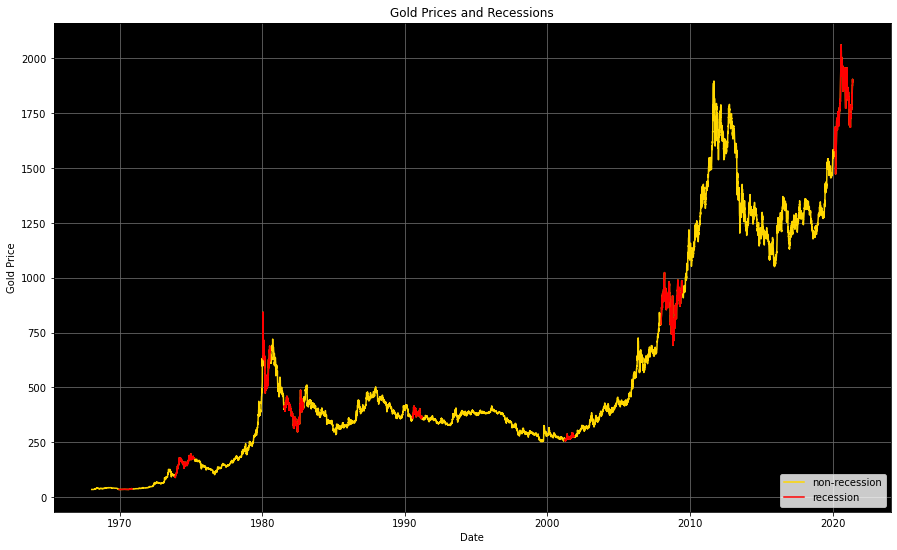

In [24]:
plt.figure(figsize = (15,9))

plt.plot(Full_Gold_TS, label = 'non-recession', color = 'gold')
ax = plt.gca()
ax.set_facecolor('black')
plt.plot(Sixties_Recession, label = 'recession', color = 'red')
plt.plot(Oil_Crisis, color = 'red')
plt.plot(Paul_Volcker, color = 'red')
plt.plot(Iranian_Revolution, color = 'red')
plt.plot(Nineties_Recession, color = 'red')
plt.plot(Dot_Com, color = 'red')
plt.plot(Great_Recession, color = 'red')
plt.plot(COVID, color = 'red')
plt.ylabel('Gold Price')
plt.xlabel('Date')
plt.grid(True, color = 'dimgrey')
plt.legend(loc = 4)
plt.title('Gold Prices and Recessions')

When a recession hits there is either an immediate increase in gold prices or follow-up effect that takes place in the years following. In 1980 Paul Volcker induced an economic recession for the purposes of fighting high inflation. We will talk about inflation soon, but as can be seen the price of gold peaked during this recession. From 1985 to 2001 the price of gold was fairly constant which is associated with an absense of any major recessions. The second longest economic expansion in US history was '120 months of economic growth from March 1991 to March 2001.' The small red blip around 2001 is the .com bubble which sees the beggining of rapid increase in gold prices. This is followed by the 2007 great recession which saw the housing market crash and the Dow Jones Average fall by 40%. After this event gold prices increase exponentially until they begin to fall in about 2012. During the recent Covid recession the gold prices peaked even though Dow Jones Average fell 33%. 

In [26]:
AG_TS = AG_df.set_index('date')
Full_Silver_TS = AG_TS['2021-05-28':'1968-01-15']
Sixties_Recession = AG_TS['1970-11-15':'1969-12-15']
Oil_Crisis = AG_TS['1975-03-15':'1973-11-15']
Paul_Volcker = AG_TS['1980-07-15':'1980-01-15']
Iranian_Revolution = AG_TS['1982-11-15':'1981-07-15']
Nineties_Recession = AG_TS['1991-03-15':'1990-07-15']
Dot_Com = AG_TS['2001-11-15':'2001-03-15']
Great_Recession = AG_TS['2009-06-15':'2007-12-15']
COVID = AG_TS['2021-05-28':'2020-02-15']

Text(0.5, 1.0, 'Silver Prices and Recessions')

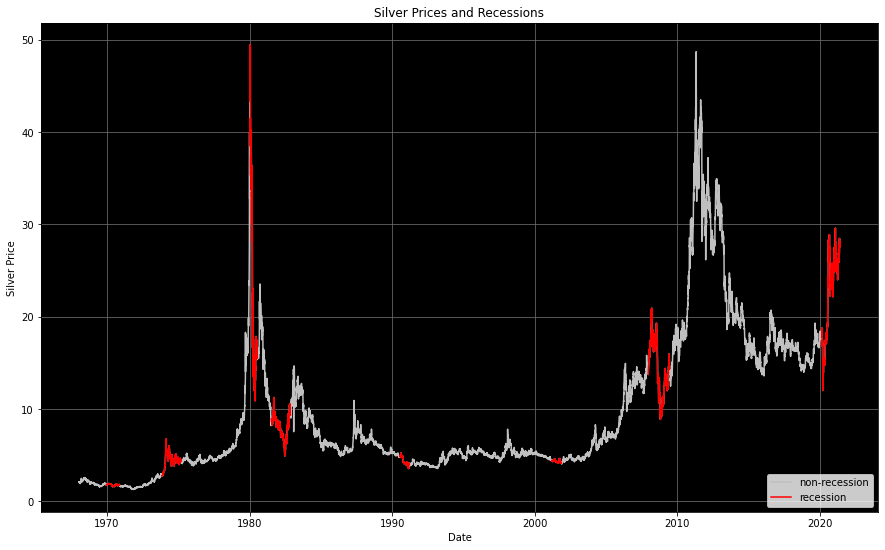

In [27]:
plt.figure(figsize = (15,9))
plt.plot(Full_Silver_TS, label = 'non-recession', color = 'silver')
ax = plt.gca()
ax.set_facecolor('black')
plt.plot(Sixties_Recession, label = 'recession', color = 'red')
plt.plot(Oil_Crisis, color = 'red')
plt.plot(Paul_Volcker, color = 'red')
plt.plot(Iranian_Revolution, color = 'red')
plt.plot(Nineties_Recession, color = 'red')
plt.plot(Dot_Com, color = 'red')
plt.plot(Great_Recession, color = 'red')
plt.plot(COVID, color = 'red')
plt.ylabel('Silver Price')
plt.xlabel('Date')
plt.grid(True, color = 'dimgrey')
plt.legend(loc = 4)
plt.title('Silver Prices and Recessions')

As can be seen silver follows similar trends to gold's reation to recessions. Silver seems to be much more volatile than gold which would make it potentially more profitable, yet also more risky.

#### Relationship between precious metal and oil markets

In [28]:
from functools import reduce

In [29]:
### Lets create a dataframe that puts precious metals, oil, and dowjones in a single dataframe
dfs = [Metals_df, Oil_df, DowJones_df]
Indicators_df = reduce(lambda left,right: pd.merge(left,right,on=['date']), dfs)

In [30]:
Indicators_df['Oil_Price_per_twenty_Barrels'] = 20*Indicators_df['Oil_Price_per_Barrel']
Indicators_df['USD_silver_per_3.96_pounds'] = 63.34*Indicators_df['USD_silver']
Indicators_df['5.4%_DowJones_slice'] = .054*Indicators_df['DowJones']
Indicators_df.head()

,date,USD_gold,USD_silver,Oil_Price_per_Barrel,DowJones,Oil_Price_per_twenty_Barrels,USD_silver_per_3.96_pounds,5.4%_DowJones_slice
0,2021-05-28,1892.45,27.630,66.31,34529.0,1326.2,1750.0842,1864.566
1,2021-05-27,1895.05,27.655,66.87,34432.0,1337.4,1751.6677,1859.328
2,2021-05-26,1904.30,28.120,66.41,34336.0,1328.2,1781.1208,1854.144
3,2021-05-25,1882.80,27.555,66.27,34429.0,1325.4,1745.3337,1859.166
4,2021-05-24,1876.85,27.645,66.13,34254.0,1322.6,1751.0343,1849.716


Text(0.5, 1.0, 'Gold and Oil Prices ')

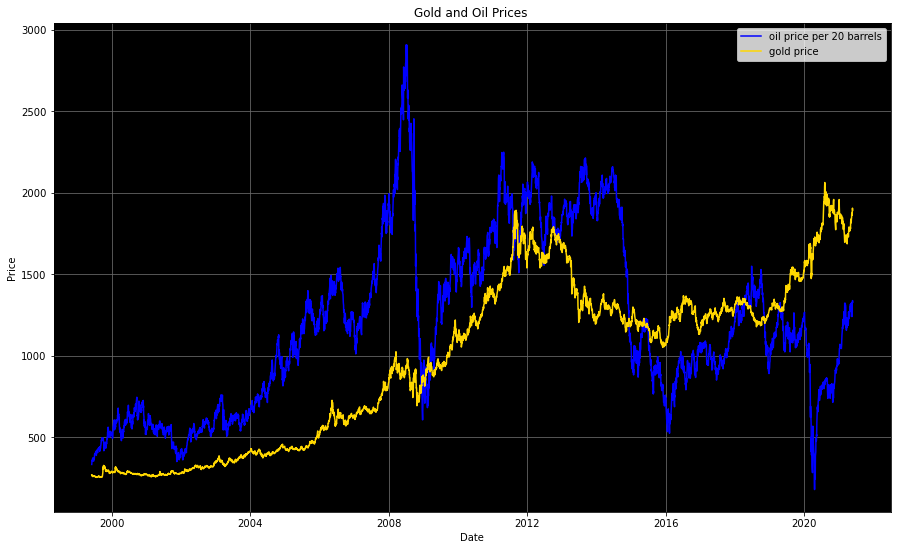

In [32]:
plt.figure(figsize = (15,9))
ax = plt.gca()
ax.set_facecolor('black')
plt.plot(Indicators_df['date'], Indicators_df['Oil_Price_per_twenty_Barrels'], color = 'blue', label = 'oil price per 20 barrels')
plt.plot(Indicators_df['date'], Indicators_df['USD_gold'], color = 'gold', label = 'gold price')
plt.legend(loc = 1)
plt.grid(True, color = 'dimgrey')
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('Gold and Oil Prices')

Gold prices seem resilient when compared to oil prices. Both oil and gold are correlated with the exception of the COVID recession. But the price of gold doesn't have the wild flucuations that oil does. 

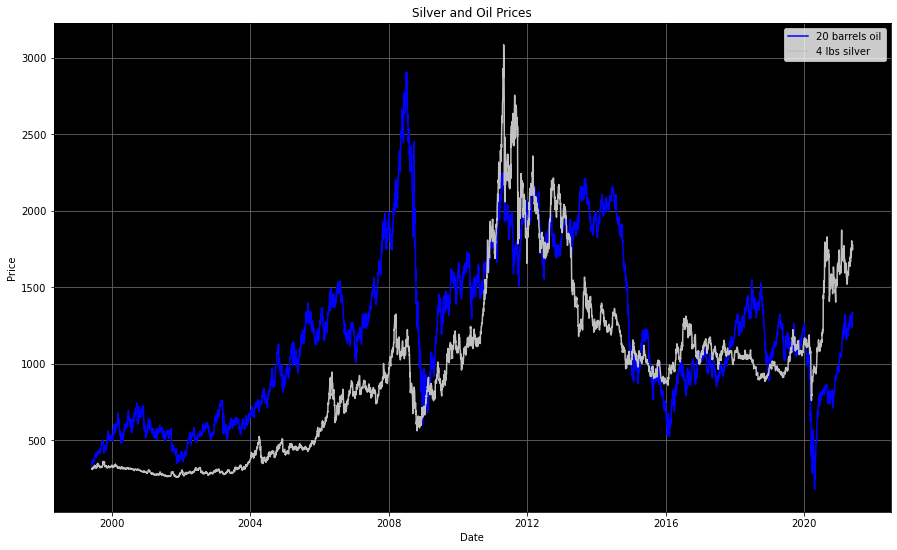

In [52]:
plt.figure(figsize = (15,9))
ax = plt.gca()
ax.set_facecolor('black')
plt.plot(Indicators_df['date'], Indicators_df['Oil_Price_per_twenty_Barrels'], color = 'blue', label = '20 barrels oil')
plt.plot(Indicators_df['date'], Indicators_df['USD_silver_per_3.96_pounds'], color = 'silver', label = '4 lbs silver')
plt.grid(True, color = 'dimgrey')
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('Silver and Oil Prices')
plt.legend(loc = 1)

Here we are comparing the price of 4 pounds of gold and 20 barrels of oil. I chose these units of measurement as they are both roughly equivalent to the price of 1 ounce of gold. As shown silver and oil follow very similar trends. The price for oil is more volatile than the price for silver. During the COVID recession there seems to be an exception as where the price of oil tanks and then rebounds to previous prices, while the the price of silver only dips slightly and then doubles compared to pre-COVID prices. 

#### Relationship between Dow Jones and precious metals

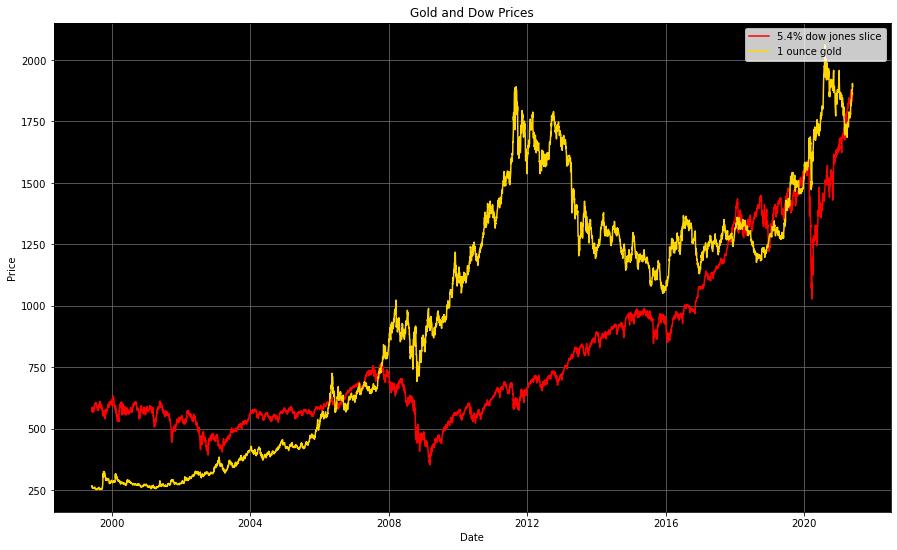

In [53]:
plt.figure(figsize = (15,9))
ax = plt.gca()
ax.set_facecolor('black')
plt.plot(Indicators_df['date'], Indicators_df['5.4%_DowJones_slice'], 'g-',  color = 'red', label = '5.4% dow jones slice')
plt.plot(Indicators_df['date'], Indicators_df['USD_gold'], color = 'gold', label = '1 ounce gold')
plt.grid(True, color = 'dimgrey')
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('Gold and Dow Prices')
plt.legend(loc = 1)

There actually doesn't seem to be much of a correlation between gold prices and the Dow Jones Industial Average. The Dow is stagnent from 2000 to 2006 during which time the price of gold triples. The price of gold holds stong and then rises when the DOW takes a 50% plunge during the 2007 financial crises. The only period in which they have similar trends would be 2016 to 2019. 

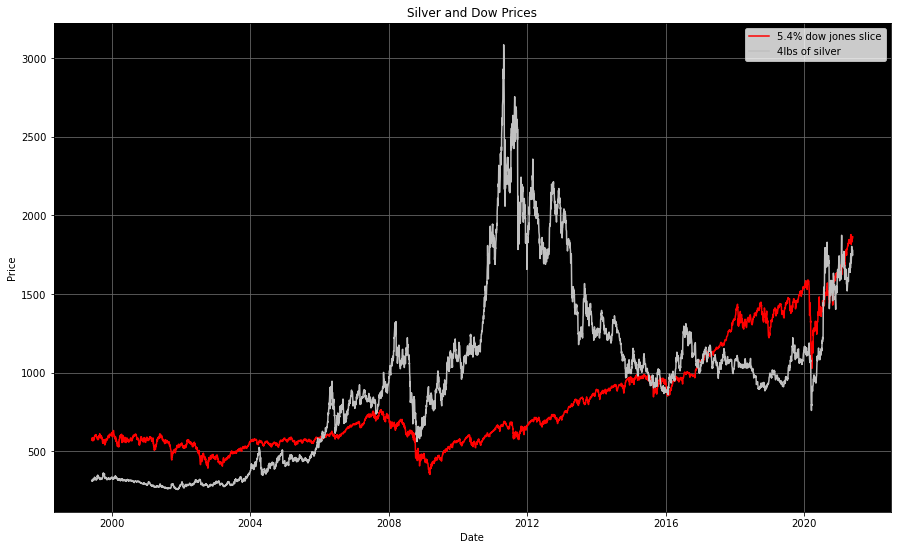

In [54]:
plt.figure(figsize = (15,9))
ax = plt.gca()
ax.set_facecolor('black')
plt.plot(Indicators_df['date'], Indicators_df['5.4%_DowJones_slice'], 'g-',  color = 'red', label = '5.4% dow jones slice')
plt.plot(Indicators_df['date'], Indicators_df['USD_silver_per_3.96_pounds'], color = 'silver', label = '4lbs of silver')
plt.grid(True, color = 'dimgrey')
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('Silver and Dow Prices')
plt.legend(loc = 1)

The price of silver is even less correlated to the Dow than the price of gold. It seems that when the stock market is in a 'bull' market people sell their silver and invest in stocks, and while the market is 'bearish' people sell their stocks and invest in precious metals. This can explain the inverse relationship between the Dow and silver prices. 

#### Relationship between inflation and precious metals

In [37]:
#How many rows contain information from 2020
len(AU_df[102:356])

254

In [38]:
AU_df['lagged'] = AU_df.USD_gold.shift(periods = -254)
AU_df['AU_annual_return'] = ((AU_df['USD_gold']-AU_df['lagged'])/AU_df['lagged'])*100
Inflation_df['Inflation_x10'] = (Inflation_df['Inflation_rate'])*10
AU_df.head()

,date,USD_gold,lagged,AU_annual_return
0,2021-05-28,1892.45,1723.30,9.815470
1,2021-05-27,1895.05,1705.15,11.136850
2,2021-05-26,1904.30,1722.75,10.538383
3,2021-05-25,1882.80,1732.45,8.678461
4,2021-05-24,1876.85,1732.80,8.313135


In [39]:
dfs = [AU_df, Inflation_df]
Inflation_AU_df = reduce(lambda left,right: pd.merge(left,right,on=['date']), dfs)
Inflation_AU_df.head()

,date,USD_gold,lagged,AU_annual_return,Inflation_rate,Inflation_x10
0,2021-05-28,1892.45,1723.30,9.815470,2.42,24.2
1,2021-05-27,1895.05,1705.15,11.136850,2.42,24.2
2,2021-05-26,1904.30,1722.75,10.538383,2.40,24.0
3,2021-05-25,1882.80,1732.45,8.678461,2.42,24.2
4,2021-05-24,1876.85,1732.80,8.313135,2.44,24.4


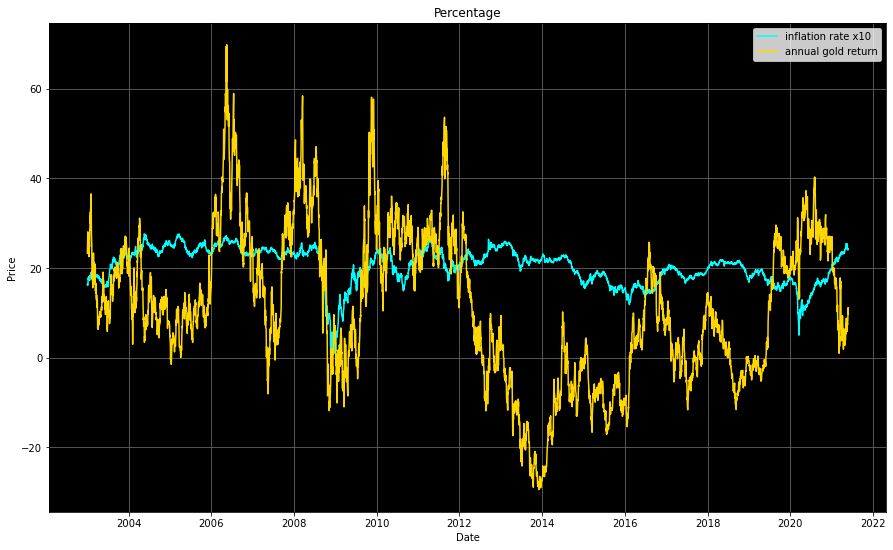

In [55]:
plt.figure(figsize = (15,9))
ax = plt.gca()
ax.set_facecolor('black')
plt.plot(Inflation_AU_df['date'], Inflation_AU_df['Inflation_x10'],  color = 'aqua', label = 'inflation rate x10')
plt.plot(Inflation_AU_df['date'], Inflation_AU_df['AU_annual_return'], color = 'gold', label = 'annual gold return')
plt.grid(True, color = 'dimgrey')
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('Percentage')
plt.legend(loc = 1)

One of the touted benefits of gold is that it can be a hedge against inflation. Inlfation has been extremely stable at around 2.5% for the last 2 decades. I had to multiply the inflation rate by 10 just so any trends could be visualized in the above graphic. There seems to be 2 points worth looking at. One the deflation during the 2007 financial crises led to the price of gold dropping, and two the recent inflation under the Biden adminstration economic policies have not effected the price of gold. The idea behind inflation driving gold prices is that when the dollar loses value people tend to flock towards gold as holding fiat currency becomes unreliable. A fear factor amplifies this effect on attitude towards economic stabilit futher increases the price of gold. 

## Part 3) Investment Strategies for Gold and Silver

#### Investing in Gold vs. Silver

As explained the the above section the purpose of investing in gold or silver is to mitigate risk. In this section I will be covering strategies on incorporating gold or silver into your portfolio. 

First we will examine the correlation between gold and silver. Does investing in both mitigate risk by further diversifying your portfolio, or are gold and silver prices so highly correlated that no diversification is added. Futher what are the advantages for each precious metal. 

In [41]:
from mizani.breaks import date_breaks 
from mizani.formatters import date_format

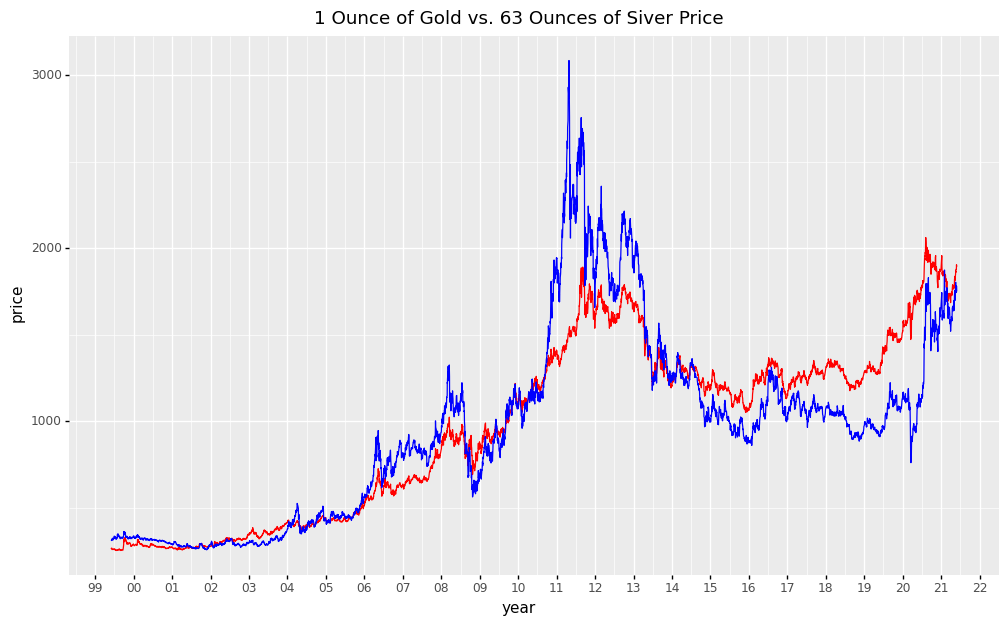

<ggplot: (8789448695793)>

In [42]:
gg = (p9.ggplot(Indicators_df, p9.aes('date'))+
      p9.scale_x_datetime(breaks=date_breaks('1 year'), labels=date_format('%y')) +
      p9.geom_line(p9.aes(y = 'USD_gold'), color = 'red') +
      p9.geom_line(p9.aes(y = 'USD_silver_per_3.96_pounds'), color = 'blue') +
      p9.theme(figure_size=(12, 7)) +
      p9.labs(title='1 Ounce of Gold vs. 63 Ounces of Siver Price', x = 'year', y = 'price'))
gg

I had to use 4 pounds of silver is roughly equal to 1 ounce of gold, and so I am comparing the prices of 1 ounce vs 4 pounds to make the chart readable. As can be seen here the two metals follow similar trends. Silver price variation seems to be an exaggeration of gold price variation. When gold prices increase the silver prices exceed that of gold per dollar invested. But inversely decreases in gold prices lead to more dramatic price reductions in silver. 

In [43]:
#How many rows contain information from 2020 for gold
len(AU_df[102:356])

254

In [44]:
#How many rows contain information from 2020 for silver
len(AG_df[102:356])

254

In [45]:
Metals_df['lagged_AU'] = Metals_df.USD_gold.shift(periods = -254)
Metals_df['AU_annual_return'] = ((Metals_df['USD_gold']-Metals_df['lagged_AU'])/Metals_df['lagged_AU'])*100
Metals_df['lagged_AG'] = Metals_df.USD_silver.shift(periods = -254)
Metals_df['AG_annual_return'] = ((Metals_df['USD_silver']-Metals_df['lagged_AG'])/Metals_df['lagged_AG'])*100
Metals_df.copy()
Metals_df = Metals_df[0:10000]

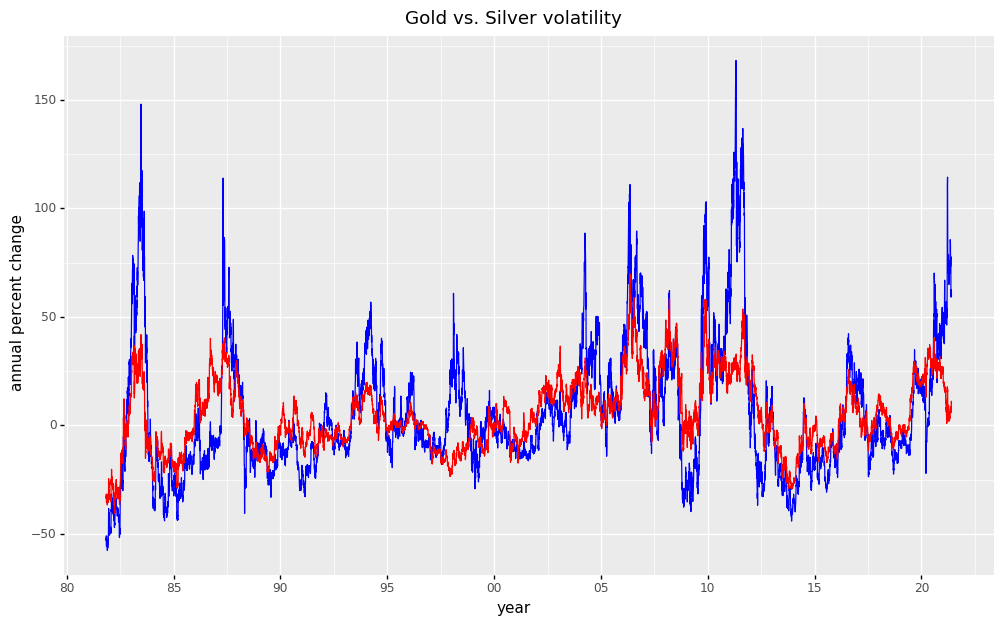

<ggplot: (8789448892694)>

In [46]:
gg = (p9.ggplot(Metals_df, p9.aes('date'))+
      p9.scale_x_datetime(breaks=date_breaks('5 year'), labels=date_format('%y')) +
      p9.geom_line(p9.aes(y = 'AG_annual_return'), color = 'blue') +
      p9.geom_line(p9.aes(y = 'AU_annual_return'), color = 'red') +
      p9.theme(figure_size=(12, 7)) +
      p9.labs(title='Gold vs. Silver volatility', x = 'year', y = 'annual percent change'))
gg

Here I use a time series lag of 1 year to track the annual percent change in prices of gold and silver. As can be seen the price of gold oscillates well within the oscillation for silver prices. Silver prices have the potential to see 100% annual return given certain investment timings, but silver also has the chance of a 50% loss in investment. Gold on the other hand is more conservative. Gold almost never drops below a 15% annual loss which happens commonly for silver prices. But gold also does not have the same potential as it never exceeds more than 50% annual increase in price. 

In [47]:
print('The correlation between gold prices silver prices is', Metals_df['USD_gold'].corr(Metals_df['USD_silver']))

The correlation between gold prices silver prices is 0.9218526014728483


#### Final Verdict

Given that the gold and silver prices have such a high correlation it is safe to assume that investing in both precious metals does little to mitigate risk. The investors dispotion towards risk would be the main factor for how they choose to invest. More risk averse individuals would be better off investing in gold at its volatility is lesser than that of silver.

### ------------------------------------------------------------------------------------------------------------------------
### Investing in gold or silver ETFs

#### What is IAU?
'The iShares Gold Trust seeks to reflect generally the performance of the price of gold.' -ishares.com

IAU is the ticker for a gold ETF(exchange traded fund) that can easily be traded on any brokerage account. It is not actively managed and is designed to allow people to invest in gold without the compications of transportation and storage. The ETF physically holds gold bars and does not engage in operations to gain profit like other gold trusts. This make IAU both less profitable and less risky. 

#### What is SLV?
'The iShares Silver Trust seeks to reflect generally the performance of the price of silver.' - ishares.com

SLV works simailar to IAU. SLV is an ETF that can be bought on your favorite brokerage account. The trust will physically buy and sell bars of silver that are stored in secure vaults around the world. 

#### Comparing the precious metal prices to ETF prices
I will be comparing the gold and silver prices to the exchange traded funds to see if they actually match in terms of investment returns.

In [48]:
dfs = [Metals_df, ETF_df]
Investment_df = reduce(lambda left,right: pd.merge(left,right,on=['date']), dfs)
Investment_df['IAU_open_52.25'] = (Investment_df['IAU_open'])*52.25
Investment_df['SLV_open_1.06'] = (Investment_df['SLV_open'])*1.06
Investment_df.head()

,date,USD_gold,USD_silver,lagged_AU,AU_annual_return,lagged_AG,AG_annual_return,SLV_open,IAU_open,IAU_open_52.25,SLV_open_1.06
0,2021-04-01,1715.85,24.315,1604.65,6.929860,13.930,74.551328,22.87,32.84,1715.890,24.2422
1,2021-03-01,1746.95,26.890,1646.60,6.094376,18.050,48.975069,24.96,33.16,1732.610,26.4576
2,2021-02-01,1857.80,29.585,1580.40,17.552518,17.725,66.911142,27.76,35.58,1859.055,29.4256
3,2020-12-01,1796.20,23.535,1456.35,23.335737,16.965,38.726790,21.93,34.50,1802.625,23.2458
4,2020-10-01,1895.55,23.620,1466.10,29.291999,17.110,38.047925,22.01,36.32,1897.720,23.3306


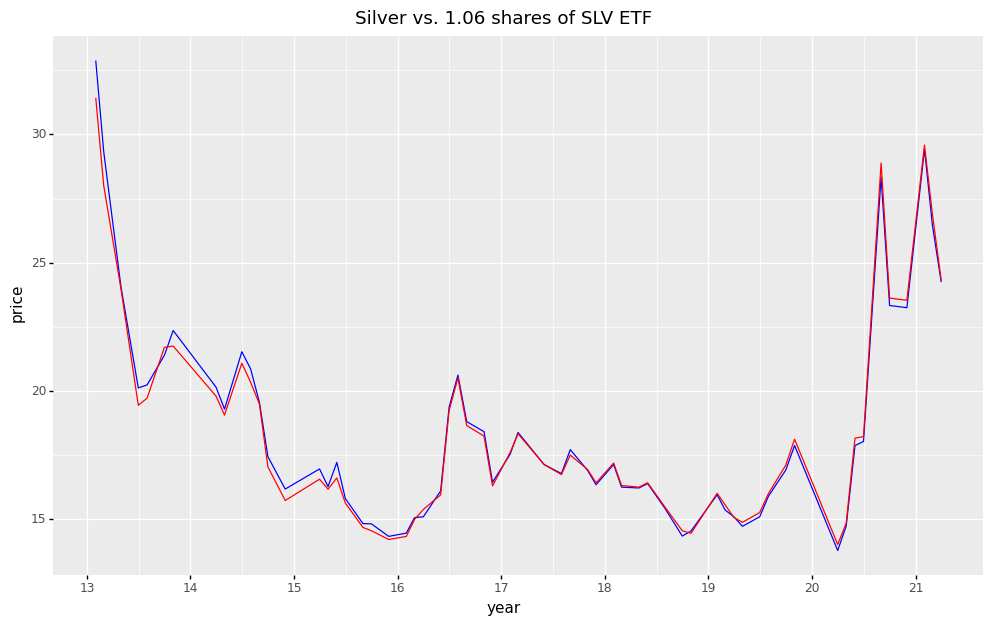

<ggplot: (8789448691601)>

In [49]:
gg = (p9.ggplot(Investment_df, p9.aes('date'))+
      p9.scale_x_datetime(breaks=date_breaks('1 year'), labels=date_format('%y')) +
      p9.geom_line(p9.aes(y = 'SLV_open_1.06'), color = 'blue') +
      p9.geom_line(p9.aes(y = 'USD_silver'), color = 'red') +
      p9.theme(figure_size=(12, 7)) +
      p9.labs(title='Silver vs. 1.06 shares of SLV ETF', x = 'year', y = 'price'))
gg

Here we are comparing 1.06 shares of SLV to 1 ounce of actual silver. The ETF security and 1 ounce of silver have different units of measurement. 1.06 shares is equivalent to 1 ounce of silver on the date 2021-04-01, and so I created a new variable based on this one date. If the ETF exactly follows the price of silver then we should see the ETF plot and silver plot as mirror images. All the historic data based on the 2021-04-01 equivalency should match which as we see is the case. The ETF seems to perfectly follow the price in silver. Investing in this exchange traded fund has the same potential as actually buying and holding silver. 

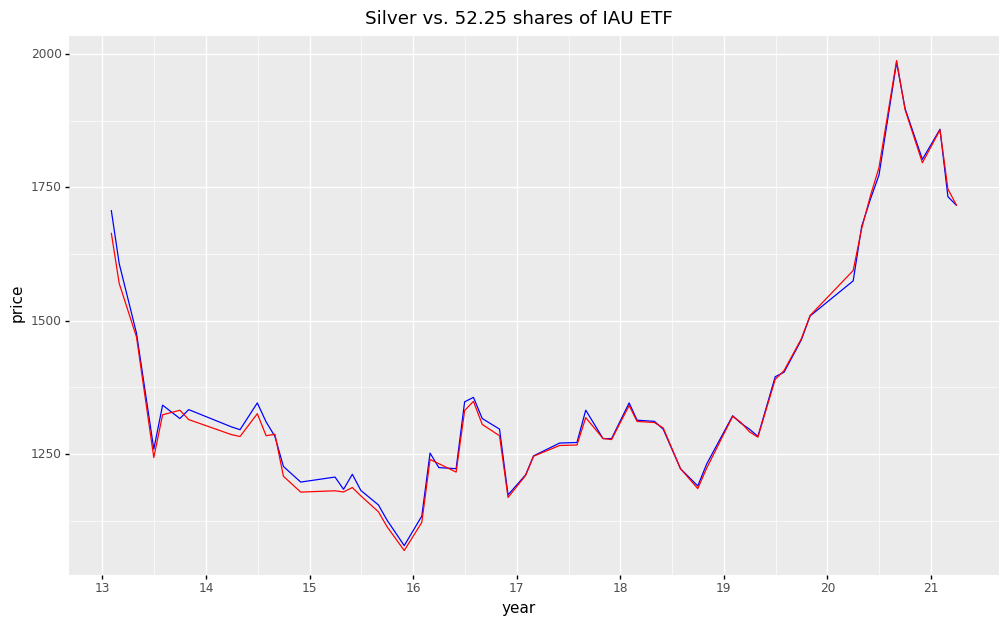

<ggplot: (8789447481182)>

In [50]:
gg = (p9.ggplot(Investment_df, p9.aes('date'))+
      p9.scale_x_datetime(breaks=date_breaks('1 year'), labels=date_format('%y')) +
      p9.geom_line(p9.aes(y = 'IAU_open_52.25'), color = 'blue') +
      p9.geom_line(p9.aes(y = 'USD_gold'), color = 'red') +
      p9.theme(figure_size=(12, 7)) +
      p9.labs(title='Silver vs. 52.25 shares of IAU ETF', x = 'year', y = 'price'))
gg

In this case we buy 52.25 securities of IAU and see that the prices of the securities and the price of gold are equivalent. And so it seems that hold 52.25 IAU securities if a good strategy for those who physically don't want the risk or burden of having gold stored in their household

In [51]:
print('The correlation between gold prices IAU ETF prices is', Investment_df['USD_gold'].corr(Investment_df['IAU_open']))
print('The correlation between silver prices SLV ETF prices is',Investment_df['USD_silver'].corr(Investment_df['SLV_open']))

The correlation between gold prices IAU ETF prices is 0.9986432616934778
The correlation between silver prices SLV ETF prices is 0.9965593842405819


#### Final Verdict

IAU and SLV are fine investments for those who wish to protect themselves against uncertainty, while not wanting to go through the process of transporting and storing physical precious metals. In the case of a home invasion gold and silver physically stored could be stolen, but yet again brokerage accounts can be hacked if your information is leaked. Both incidences should be covered by certain insurances, but a mixed approach for the folks who are extremely risk averse can be implemented. 